In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import RobustScaler
# from ecg import ecg_feature_computation
import matplotlib.pyplot as plt
# from hrvanalysis import get_time_domain_features,get_geometrical_features,get_csi_cvi_features,get_poincare_plot_features
# from hrvanalysis import get_frequency_domain_features
from typing import List
import numpy as np
import scipy.signal as signal
from copy import deepcopy
import datetime
import numpy as np
from scipy.stats import iqr
from enum import Enum
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,roc_curve,auc,precision_score,recall_score,accuracy_score,classification_report,make_scorer,precision_recall_curve
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed
from sklearn.preprocessing import StandardScaler

def f1Bias_scorer_CV(probs, y, ret_bias=False):

    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)


def fit_model(X,y,groups,k,paramGrid):
    X = np.delete(X,k,axis=1)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    return np.array([a,k]).reshape(-1)

def get_results_backward_elimination(X,y,groups):
    
    
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [100,10,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3]],
                 'rf__probability':[True]
    }
    feature_names = ['var','iqr','mean','median','80th','20th','heartrate','vlf','lf','hf','lf-hf']
#     gg = fit_model(deepcopy(X),y,groups,k,paramGrid)
    data = []
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring='f1',verbose=5)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    data.append(['all',a])
    print(data)
    while len(feature_names)>1:
        results = Parallel(n_jobs=30,verbose=4)(delayed(fit_model)(deepcopy(X),y,groups,k,paramGrid) for k,name in enumerate(feature_names))
        results = np.array(results)
        print(results,results.shape)
        ind_min = np.argmax(results[:,0])
        min_f1 = results[ind_min,0]
        min_index = np.int64(results[ind_min,1])
        name_feature = feature_names[min_index]
        data.append([name_feature,min_f1])
        X = np.delete(X,min_index,axis=1)
        feature_names = feature_names[:min_index] + feature_names[(min_index+1):]
        print(data)
    return data
    
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

def get_results(X,y,groups):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    delta = 0.1
    paramGrid = {'rf__kernel': ['rbf'],
                 'rf__C': [10,1,100,200],
                 'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
                 'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
                 'rf__probability':[True]
    }
    pca = PCA(n_components=4)
    clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
    gkf = GroupKFold(n_splits=len(np.unique(groups)))
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                               scoring=my_score,verbose=5)
    print(X.shape)
    grid_search.fit(X,y)
    clf = grid_search.best_estimator_
    
    probs = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs),a,b)
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = np.int64(probs)
    print(classification_report(y,y_pred),confusion_matrix(y,y_pred))
    clf = CalibratedClassifierCV(clf, cv=10, method='sigmoid')
    clf.fit(X,y)
    print(f1_score(y,clf.predict(X)))
    return clf,np.array([f1_score(y,y_pred),precision_score(y,y_pred),recall_score(y,y_pred)])

def get_label(user_data,st,et):
    label = 2
    for k in range(user_data.shape[0]):
        if st>=user_data[k,0] and et<=user_data[k,1]:
            label = user_data[k,2]

    return label

def get_ecg_windowss(rr_interval,window=0):
    window_col,ts_col = [],[]
    if window==0:
        n = 30
    else:
        n = (.5*60)/(window/2)
    m = np.mean(rr_interval[:,1])
    s = np.std(rr_interval[:,1])
    ts_array = np.arange(rr_interval[0,0],rr_interval[-1,0],30000)
    for t in ts_array:
        index = np.where((rr_interval[:,0]>=t)&(rr_interval[:,0]<=t+60000))[0]
        if len(index)<n:
            continue
        rr_temp = rr_interval[index,:]
        rr_temp = rr_temp[np.where((rr_temp[:,1]>m-3*s)&(rr_temp[:,1]<m+3*s))[0],:]
        if len(rr_temp)<n:
            continue
        window_col.append(rr_temp)
        ts_col.append(t)
    return window_col,ts_col

def get_rr_features(a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])

import numpy as np
from scipy import interpolate, signal
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import matplotlib.patches as mpatches
from collections import OrderedDict

def frequencyDomain(RRints,tmStamps, band_type = None, lf_bw = 0.11, hf_bw = 0.1, plot = 0):
    """ Computes frequency domain features on RR interval data
    
    Parameters:
    ------------
    RRints : list, shape = [n_samples,]
           RR interval data
    
    band_type : string, optional
             If band_type = None, the traditional frequency bands are used to compute 
             spectral power:
           
                 LF: 0.003 - 0.04 Hz
                 HF: 0.04 - 0.15 Hz
                 VLF: 0.15 - 0.4 Hz           
           
             If band_type is set to 'adapted', the bands are adjusted according to 
             the protocol laid out in:
           
             Long, Xi, et al. "Spectral boundary adaptation on heart rate 
             variability for sleep and wake classification." International 
             Journal on Artificial Intelligence Tools 23.03 (2014): 1460002. 
                        
    lf_bw : float, optional
          Low frequency bandwidth centered around LF band peak frequency
          when band_type is set to 'adapted'. Defaults to 0.11
             
    hf_bw : float, optional
          High frequency bandwidth centered around HF band peak frequency
          when band_type is set to 'adapted'. Defaults to 0.1
          
    plot : int, 1|0
          Setting plot to 1 creates a matplotlib figure showing frequency
          versus spectral power with color shading to indicate the VLF, LF,
          and HF band bounds.
    
    Returns:
    ---------
    freqDomainFeats : dict
                   VLF_Power, LF_Power, HF_Power, LF/HF Ratio              
    """

    #Remove ectopic beats
    #RR intervals differing by more than 20% from the one proceeding it are removed
    NNs = []
    tss = []
    for c, rr in enumerate(RRints):        
        if abs(rr - RRints[c-1]) <= 0.20 * RRints[c-1]:
            NNs.append(rr)
            tss.append(tmStamps[c])
            
            
    frequency_range = np.linspace(0.001, 1, 10000)
    NNs = np.array(NNs)
    NNs = NNs - np.mean(NNs)
    result = signal.lombscargle(tss, NNs, frequency_range)
        
    #Pwelch w/ zero pad     
    fxx = frequency_range 
    pxx = result 
    
    vlf= (0.003, 0.04)
    lf = (0.04, 0.15)
    hf = (0.15, 0.4)
    
    plot_labels = ['VLF', 'LF', 'HF']
        
    if band_type == 'adapted':     
            
        vlf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])]))[0][0]] 
        lf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])]))[0][0]]
        hf_peak = fxx[np.where(pxx == np.max(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])]))[0][0]]
    
        peak_freqs =  (vlf_peak, lf_peak, hf_peak) 
            
        hf = (peak_freqs[2] - hf_bw/2, peak_freqs[2] + hf_bw/2)
        lf = (peak_freqs[1] - lf_bw/2, peak_freqs[1] + lf_bw/2)   
        vlf = (0.003, lf[0])
        
        if lf[0] < 0:
            print('***Warning***: Adapted LF band lower bound spills into negative frequency range')
            print('Lower thresold of LF band has been set to zero')
            print('Adjust LF and HF bandwidths accordingly')
            lf = (0, lf[1])        
            vlf = (0, 0)
        elif hf[0] < 0:
            print('***Warning***: Adapted HF band lower bound spills into negative frequency range')
            print('Lower thresold of HF band has been set to zero')
            print('Adjust LF and HF bandwidths accordingly')
            hf = (0, hf[1])        
            lf = (0, 0)        
            vlf = (0, 0)
            
        plot_labels = ['Adapted_VLF', 'Adapted_LF', 'Adapted_HF']

    df = fxx[1] - fxx[0]
    vlf_power = np.trapz(pxx[np.logical_and(fxx >= vlf[0], fxx < vlf[1])], dx = df)      
    lf_power = np.trapz(pxx[np.logical_and(fxx >= lf[0], fxx < lf[1])], dx = df)            
    hf_power = np.trapz(pxx[np.logical_and(fxx >= hf[0], fxx < hf[1])], dx = df)             
    totalPower = vlf_power + lf_power + hf_power
    
    #Normalize and take log
    vlf_NU_log = np.log((vlf_power / (totalPower - vlf_power)) + 1)
    lf_NU_log = np.log((lf_power / (totalPower - vlf_power)) + 1)
    hf_NU_log = np.log((hf_power / (totalPower - vlf_power)) + 1)
    lfhfRation_log = np.log((lf_power / hf_power) + 1)   
    
    freqDomainFeats = {'VLF_Power': vlf_NU_log, 'LF_Power': lf_NU_log,
                       'HF_Power': hf_NU_log, 'LF/HF': lfhfRation_log}
                       
    if plot == 1:
        #Plot option
        freq_bands = {'vlf': vlf, 'lf': lf, 'hf': hf}
        freq_bands = OrderedDict(sorted(freq_bands.items(), key=lambda t: t[0]))
        colors = ['lightsalmon', 'lightsteelblue', 'darkseagreen']
        fig, ax = plt.subplots(1)
        ax.plot(fxx, pxx, c = 'grey')
        plt.xlim([0, 0.40])
        plt.xlabel(r'Frequency $(Hz)$')
        plt.ylabel(r'PSD $(s^2/Hz$)')
        
        for c, key in enumerate(freq_bands):
            ax.fill_between(fxx[min(np.where(fxx >= freq_bands[key][0])[0]): max(np.where(fxx <= freq_bands[key][1])[0])],
                            pxx[min(np.where(fxx >= freq_bands[key][0])[0]): max(np.where(fxx <= freq_bands[key][1])[0])],
                            0, facecolor = colors[c])
            
        patch1 = mpatches.Patch(color = colors[0], label = plot_labels[2])
        patch2 = mpatches.Patch(color = colors[1], label = plot_labels[1])
        patch3 = mpatches.Patch(color = colors[2], label = plot_labels[0])
        plt.legend(handles = [patch1, patch2, patch3])
        plt.show()

    return freqDomainFeats


def combine_data_sobc(window_col,ts_col,label_data,participant):
    feature_matrix = []
    user_col = []
    label_col = []
    for i,item in enumerate(window_col):
#         try:
        r = frequencyDomain(item[:,1]/1000,item[:,0]/1000)
#         except Exception as:
#             continue
        feature = np.array(list(get_rr_features(item[:,1])) + list(r.values()))
        feature_matrix.append(feature.reshape(-1,len(feature)))
        user_col.append(participant)
        label_col.append(get_label(label_data,ts_col[i],ts_col[i]+50000))
    return np.array(feature_matrix).reshape(-1,11),user_col,label_col

def get_2_sec_ts(rr_ppg_int,window=2):
    m = np.mean(rr_ppg_int[:,1])
    s = np.std(rr_ppg_int[:,1])
    ts_array = np.arange(rr_ppg_int[0,0],rr_ppg_int[-1,0],1000*window/2)
    rr_interval = np.zeros((0,2))
    for t in ts_array:
        index = np.where((rr_ppg_int[:,0]>=t-1000*window//2)&(rr_ppg_int[:,0]<=t+1000*window//2))[0]
        if len(index) < 1:
            continue
        rr_interval = np.concatenate((rr_interval,np.array([t,np.mean(rr_ppg_int[index,1])]).reshape(-1,2)))
    return rr_interval

def get_dd(ecg_rr,label_data,window,participant):
    window_col,ts_col = get_ecg_windowss(ecg_rr,window)
    feature_matrix,user_col,label_col = combine_data_sobc(window_col,ts_col,label_data,participant)
    rr_70th = np.percentile(feature_matrix[:,2],20)
    rr_95th = np.percentile(feature_matrix[:,2],99)
    index = np.where((feature_matrix[:,2]>rr_70th)&(feature_matrix[:,2]<rr_95th))[0]
    means = np.mean(feature_matrix[index],axis=0)
    stds = np.std(feature_matrix[index],axis=0)
    feature_matrix = (feature_matrix - means)/stds
    temp = np.array(label_col)
    labels = np.array(label_col)
    return feature_matrix,user_col,label_col

def get_precision_recall_f1(path,window):
    participants = os.listdir(path)
    X,y,groups = np.zeros((0,11)),[],[]
    data_col = []
    for participant in participants:
        file_list = os.listdir(path+'/'+participant)
        for file in file_list:
            final_path = path+'/'+participant+'/'+file+'/'
            if 'ecg_rr_final.csv' not in os.listdir(final_path):
                continue
            else:
                ecg_rr = pd.read_csv(final_path+'ecg_rr_final.csv',header=None,sep=',').values
            if ecg_rr.shape[0]<500:
                continue
            if window>0:
                ecg_rr = get_2_sec_ts(ecg_rr,window)
            label_data = pd.read_csv(final_path+'label_data.csv',header=None,sep=',').values
            data_col.append([ecg_rr,label_data,window,participant])
    final = Parallel(n_jobs=30,verbose=3)(delayed(get_dd)(*a) for a in data_col)
    for feature_matrix,user_col,label_col in final:
        X = np.concatenate((X,feature_matrix))
        y.extend(label_col)
        groups.extend(user_col)
    print(X.shape)
    y = np.array(y)
    groups = np.array(groups)
    index = np.where(y<2)[0]
    X,y,groups = X[index],y[index],groups[index]
    print(X.shape,len(y),sum(y),len(np.unique(groups)))
    return get_results(X,y,groups)
#     return get_results_backward_elimination(X,y,groups)
            

In [2]:
from scipy.stats.mstats_basic import winsorize
import pickle
path = '/home/jupyter/mullah/Test/data_yield/data/sobc_2nd_chance/'
all_results = []
for duration in [0]:
    clf,temp = get_precision_recall_f1(path,duration)
    temp = [duration]+list(temp)
    all_results.append(np.array(temp))
# #     pickle.dump(all_results,open('../data/rice/stress_results.p','wb'))
#     print(temp)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   4 out of  30 | elapsed:    9.8s remaining:  1.1min
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:   15.1s remaining:   15.1s
[Parallel(n_jobs=30)]: Done  26 out of  30 | elapsed:   20.1s remaining:    3.1s


(5117, 11)
(3031, 11) 3031 780.0 29
(3031, 11)


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   23.0s finished


Fitting 29 folds for each of 256 candidates, totalling 7424 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1362 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2082 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2496 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2946 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4512 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5106 tasks      | 

0.9254055177755758 0.7928483353884093 0.31562085426806746
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92      2251
         1.0       0.76      0.82      0.79       780

    accuracy                           0.89      3031
   macro avg       0.85      0.87      0.86      3031
weighted avg       0.89      0.89      0.89      3031
 [[2052  199]
 [ 137  643]]
0.7873799725651578


In [4]:
pickle.dump(clf,open('../models/stress_ecg_final.p','wb'))

In [ ]:
pickle.dump(f,open('../models/stress_ecg_results.p','wb'))
f

In [ ]:
all_results = pickle.load(open('../data/rice/stress_results.p','rb'))

In [ ]:
all_results

In [ ]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,8))
plt.bar(np.array(range(0,df.shape[0]*4,4)),df[:,1],1,label='F1 score')
plt.bar(np.array(range(1,df.shape[0]*4,4)),df[:,2],1,label='Precision score')
plt.bar(np.array(range(2,df.shape[0]*4,4)),df[:,3],1,label='Recall score')
plt.xticks(np.array(range(1,df.shape[0]*4,4)),['No \n smoothing']+list(np.arange(2,16,1)),rotation=60)
plt.xlabel('Moving Average Duration')
plt.legend(ncol=3)
plt.title('Stress Detection from ECG')
plt.ylim([0,1])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
y = np.array(y)
groups = np.array(groups)
y = y[~np.isnan(X).any(axis=1)]
groups = groups[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
print(X.shape,len(np.unique(groups)))
for user in np.unique(groups):
    index = np.where(groups==user)[0]
    X[index,:] = StandardScaler().fit_transform(X[index,:])
# X[X>4] = 4
# X[X<-4] = -4
index = np.where(y<2)[0]
X,y,groups = X[index],y[index],groups[index]
print(X.shape,len(np.unique(groups)))

In [ ]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed

delta = 0.1

paramGrid = {'rf__kernel': ['rbf'],
             'rf__C': [11,1000],
             'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-6, -2, .25)],
             'rf__class_weight': [{0: w, 1: 1 - w} for w in [.2,.3,.25,.35]],
             'rf__probability':[True]
}
pca = PCA(n_components=4)
clf = Pipeline([('sts',StandardScaler()),('rf', SVC())])
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='accuracy',verbose=5)
grid_search.fit(X[:,:],y)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups),n_jobs=20)
print(classification_report(y,y_pred))

In [ ]:
import pickle
print(clf)
clf.fit(X,y)
pickle.dump(clf,open('../models/stress_model_ecg_2.p','wb'))

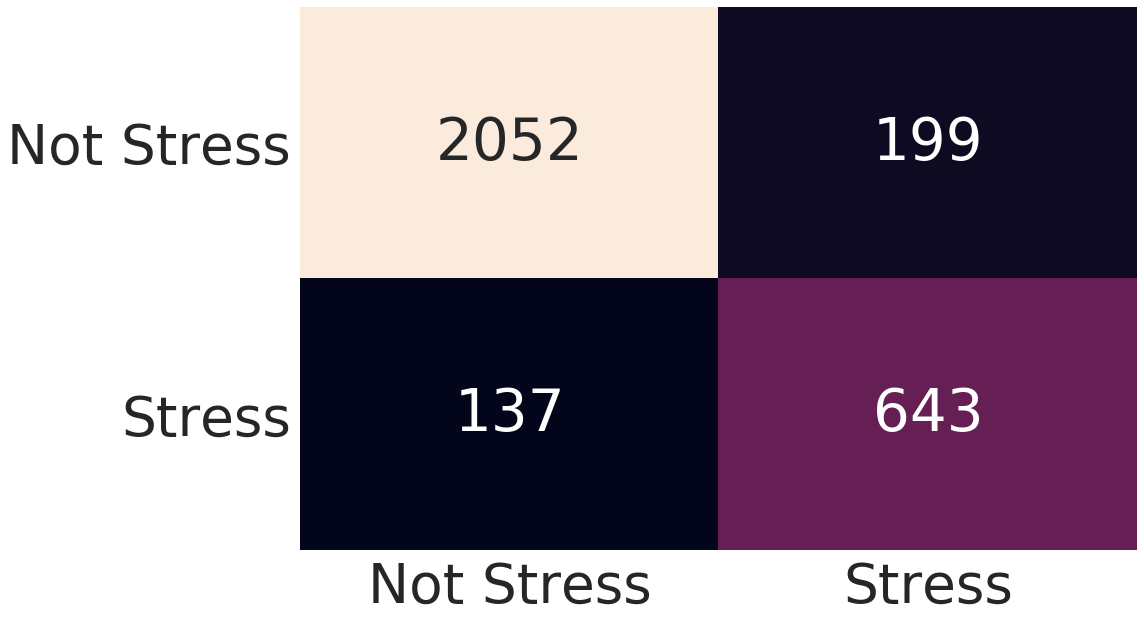

In [28]:
# from sklearn.metrics import plot_confusion_matrix
# import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
mats = np.array([[2052,  199],
 [ 137,  643]])
# mats
sns.set(font_scale=5)
# df_cm = pd.DataFrame(mats, index = [i for i in ['Not Stress','Stress']],
#                   columns = [i for i in ['Not Stress','Stress']])
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size':30})
sns.heatmap(mats, annot=True,fmt='g',annot_kws={"fontsize":58},cbar=False)
plt.xticks([.5,1.5],['Not Stress','Stress'])
plt.yticks([0.5,1.5],['Not Stress','Stress'],rotation=0)
plt.savefig('ecg_conf.pdf',dps=1e6,bbox_inches='tight')
plt.show()

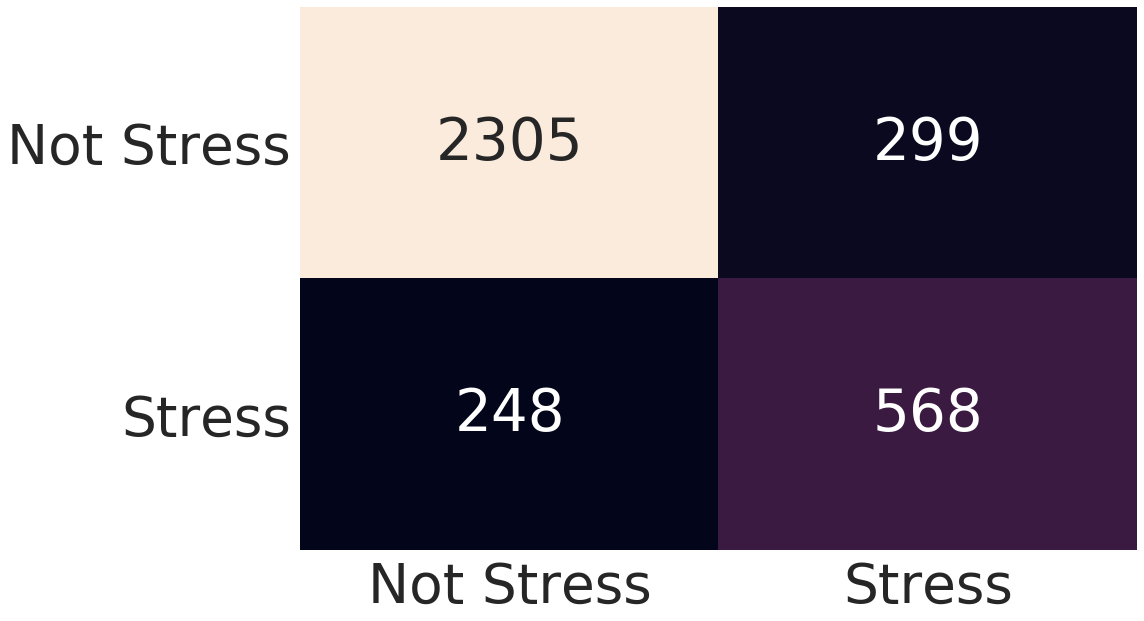

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
mats = np.array([[2305,  299],
 [ 248,  568]])
# mats
sns.set(font_scale=5)
# df_cm = pd.DataFrame(mats, index = [i for i in ['Not Stress','Stress']],
#                   columns = [i for i in ['Not Stress','Stress']])
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size':30})
sns.heatmap(mats, annot=True,fmt='g',annot_kws={"fontsize":58},cbar=False)
plt.xticks([.5,1.5],['Not Stress','Stress'])
plt.yticks([0.5,1.5],['Not Stress','Stress'],rotation=0)
plt.savefig('ppg_conf.pdf',dps=1e6,bbox_inches='tight')
plt.show()

In [ ]:
### from sklearn.decomposition import PCA
from pprint import pprint
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
warnings.filterwarnings('ignore')
from sklearn import metrics

def Twobias_scorer_CV(probs, y, ret_bias=False):
    db = np.transpose(np.vstack([np.array(probs).reshape(-1), np.array(y).reshape(-1)]))
    db = db[np.argsort(db[:, 0]), :]

    pos = np.sum(y == 1)
    n = len(y)
    neg = n - pos
    tp, tn = pos, 0
    lost = 0

    optbias = []
    minloss = 1

    for i in range(n):
        #		p = db[i,1]
        if db[i, 1] == 1:  # positive
            tp -= 1.0
        else:
            tn += 1.0

        # v1 = tp/pos
        #		v2 = tn/neg
        if tp / pos >= 0.95 and tn / neg >= 0.95:
            optbias = [db[i, 0], db[i, 0]]
            continue

        running_pos = pos
        running_neg = neg
        running_tp = tp
        running_tn = tn

        for j in range(i + 1, n):
            #			p1 = db[j,1]
            if db[j, 1] == 1:  # positive
                running_tp -= 1.0
                running_pos -= 1
            else:
                running_neg -= 1

            lost = (j - i) * 1.0 / n
            if running_pos == 0 or running_neg == 0:
                break

            # v1 = running_tp/running_pos
            #			v2 = running_tn/running_neg

            if running_tp / running_pos >= 0.95 and running_tn / running_neg >= 0.95 and lost < minloss:
                minloss = lost
                optbias = [db[i, 0], db[j, 0]]

    if ret_bias:
        return -minloss, optbias
    else:
        return -minloss
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    parameters : dict or None
        Parameters to be set on the estimator.
    cv:	Cross-validation fold indeces
    Returns
    -------
    score : float
        CV score on whole set.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    estimator.set_params(**parameters)
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)

    return [score, parameters]  # scoring_time
    
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    probs = cross_val_predict(estimator, X, y, cv=cv,method='predict_proba')[:,1]
#     for train, test in cv:
#         temp = estimator.fit(X[train], y[train]).predict_proba(X[test])
#         probs[test] = temp[:, 1]

    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise'):

        super(ModifiedGridSearchCV, self).__init__(
                estimator, param_grid, scoring, fit_params, n_jobs, iid,
                refit, cv, verbose, pre_dispatch, error_score)

    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
#         cv = check_cv(cv, X, y, classifier=is_classifier(estimator))

        if self.verbose > 0:
#             if isinstance(parameter_iterable, Sized):
            n_candidates = len(parameter_iterable)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv)
                for parameters in parameter_iterable)
#         print(out)
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]

        if self.refit:
            # fit the best estimator using the entire dataset
            # clone first to work around broken estimators
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
#             if y is not None:
#                 best_estimator.fit(X, y, **self.fit_params)
#             else:
#                 best_estimator.fit(X, **self.fit_params)
            self.best_estimator_ = best_estimator

        return self

In [ ]:
gkf = GroupKFold(n_splits=len(np.unique(groups)))
X1 = preprocessing.StandardScaler().fit_transform(X)
delta = 0.1
parameters1 = {'kernel': ['rbf'],
              'C': np.logspace(0,2,2),
              'gamma': np.logspace(-9,9,10),
              'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
              'probability':[True],
              'verbose':[False],
              'cache_size':[2000]}
parameters = {
    'min_samples_leaf': [4],
    'max_features': [.7,1],
    'n_estimators': [100,200,300],
    'n_jobs': [-1],
    'criterion':['gini','entropy'],
    'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
    'random_state': [42]
       }
svc = SVC()
# svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups), 
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
grid_search = ModifiedGridSearchCV(svc, parameters1, cv=list(gkf.split(X1,y,groups=groups)),
                                   n_jobs=20, scoring=f1Bias_scorer_CV, verbose=1, iid=False)
grid_search.fit(X1,y)
clf = grid_search.best_estimator_
clf

In [ ]:
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
clf.probability = True
CV_probs = cross_val_probs(clf, X1, y, gkf.split(X1,y,groups=groups))
# score, bias = Twobias_scorer_CV(CV_probs, y, True)
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
classified = range(n)
print(score,bias)

f = np.zeros((len(y),2))

data = pd.DataFrame()
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

data['groups'] = groups
data['original'] = [[i] for i in y]
data['predicted'] = [[i] for i in predicted]
f_scores = []
data = data.groupby('groups').sum()
for i in range(data.shape[0]):
    f_scores.append(f1_score(data['original'][i],data['predicted'][i]))
print(np.median(f_scores))

In [ ]:
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
def plot_confusion_matrix(cm, classes=['Not Stress','Stress'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('result.png')
    plt.show()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
predicted = cross_val_predict(clf, X, y, cv=gkf.split(X,y,groups=groups),n_jobs=24)
plot_confusion_matrix(confusion_matrix(y,predicted))
print(f1_score(y,predicted),precision_score(y,predicted),recall_score(y,predicted))

In [ ]:
from sklearn.feature_selection import RFECV
svc = predictor
gkf = GroupKFold(n_splits=len(np.unique(groups)))
rfecv = RFECV(estimator=svc, step=1, cv=gkf.split(X,y,groups=groups),
              scoring='f1',n_jobs=24)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
np.power(2,-1)

In [ ]:
import xgboost

In [ ]:
a = np.array([[1/2,1/3,1/6],[0,1/3,2/3],[1/2,0,1/2]])

In [ ]:
np.matmul(np.matmul(a,a),a)

In [ ]:
np.float.as_integer_ratio(0.36111111)